- title: "Neural style transfer 2: style"
- description: "Feature visualization with PyTorch"
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
# Imports
import torch
import torchvision
from torch import nn
import skimage
from skimage import transform
from skimage import io
# from im_func import show_image, timer
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from time import time
import contextlib

@contextlib.contextmanager
def timer(msg='timer'):
    tic = time()
    yield
    return print(f"{msg}: {time() - tic:.2f}")

In [19]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406]) # Fixed values for PyTorch pretrained models
rgb_std = torch.tensor([0.229, 0.224, 0.225])

class Image(nn.Module):
    def __init__(self, img=None, optimizable=True, img_shape=[64,64], jit_max=2, angle_max=2.0):
        super(Image,self).__init__()
        
        self.img_shape = img_shape
        
        if type(img)==type(None):
            self.img = torch.randn([1, 3] + self.img_shape)
        else:
            self.img = img
            self.img = self.preprocess()

        if optimizable == True:
            self.img = nn.Parameter(self.img)
         
        self.jit_i = 0
        self.jit_j = 0
        self.jit_max = jit_max
        self.angle = 0.0
        self.angle_max = angle_max
    def preprocess(self):
        with torch.no_grad():
            transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToPILImage(),
                torchvision.transforms.Resize(self.img_shape),
                torchvision.transforms.ToTensor(),
            ])
            return transforms(self.img).unsqueeze(0)
            

    def postprocess(self):
        with torch.no_grad():
            img = self.img.data[0].to(rgb_std.device).clone()
        return torchvision.transforms.ToPILImage()(img.permute(1, 2, 0).permute(2, 0, 1))
          
    def jittered_image(self):
        with torch.no_grad():
            jit_max = 2
            temp = np.random.standard_normal(2)*2.0
            self.jit_i += temp[0]
            self.jit_j += temp[1]

            self.angle += np.random.standard_normal(1)[0]*1.0
            self.angle = np.clip(self.angle,-self.angle_max,self.angle_max)
            self.jit_i, self.jit_j = np.clip([self.jit_i, self.jit_j],-self.jit_max,self.jit_max)#.astype(int)
            print(self.angle, self.jit_i, self.jit_j, temp)
            return torchvision.transforms.functional.affine(self.img.data, angle=self.angle, translate=(self.jit_i/self.img_shape[1], self.jit_j/self.img_shape[0]), scale=1., shear=[0.0,0.0])#,interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
            
        
    def forward(self, jitter=False):
        if jitter:
            return self.jittered_image().to(device)
        else:
            return self.img.to(device)
            

In [20]:
pretrained_net = torchvision.models.vgg16(pretrained=True)#.features.to(device).eval()
display(pretrained_net.features)
content_layer = [7]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [21]:
class Losses(nn.Module):
    def __init__(self, img_ref, 
                 content_weight=1.0, tv_weight_ini=0.0, clamp_weight_ini=1.0, int_weight_ini=0.0, 
                 alpha=6, beta=1.5,
                 weight_adjust_bounds=[0.01,0.1],
                 weight_adjust_fac=[1.5, 0.75]):
        super(Losses,self).__init__()
        # img_ref is used to compute a reference total variation and reference intensity
        # tv_weight: weight of the total variation regularizer
        # int_weight: weight of the intensity regularizer
        # alpha: exponent for the intensity regularizer
        # beta: exponent for the total variation regularizer
        self.content_weight = content_weight
        self.tv_weight = tv_weight_ini
        self.int_weight = int_weight_ini
        self.clamp_weight = clamp_weight_ini
        self.content_loss = 0.0
        self.tv_loss = 0.0
        self.int_loss = 0.0
        self.total_loss = 0.0
        
        self.alpha = alpha
        self.beta = beta
        
        self.B, self.V = self.get_regularizer_refs(img_ref)
        
        self.weight_adjust_bounds = weight_adjust_bounds
        self.weight_adjust_fac = weight_adjust_fac
        

    def get_content_loss(self, Y_hat, Y, reduction='mean'):
        # Mean squared error between generated and content image
        loss = 0
#         for i in range(len(feature_map_content)):
#             loss += torch.mean((feature_map_content[i]-feature_map_gen[i])**2)
#         return loss
        for y_hat, y in zip(Y_hat,Y):
            loss += F.mse_loss(y_hat, y.detach(),reduction=reduction)
        return loss
    
    
    def get_style_loss(gram_style_image, gram_generated_image):
        loss = 0
        for A, G in zip(gram_style_image,gram_generated_image):
            loss += F.mse_loss(G, A.detach(),reduction='sum')
        return loss
    
    def get_regularizer_refs(self, img):
        eps = 1e-10
        L2 = torch.sqrt(img[:,0,:,:]**2 + img[:,1,:,:]**2 + img[:,2,:,:]**2 + eps)
        B = L2.mean()

        d_dx = img[:,:,1:,:]-img[:,:,:-1,:]
        d_dy = img[:,:,:,1:]-img[:,:,:,:-1]
        L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2 + eps)
        V = L2.mean()
        return B, V

    def get_int_loss(self, img):
        # Intensity loss
        H = img.shape[2]
        W = img.shape[3]
        eps = 1e-10
        L2 = torch.sqrt(img[:,0,:,:]**2 + img[:,1,:,:]**2 + img[:,2,:,:]**2 + eps)
        
        loss = 1./H/W/(self.B**self.alpha) * torch.sum(L2**self.alpha)
        
        return loss

    def get_clamp_loss(self, img):
#         loss = torch.sum(img[img>1.0]**2) + torch.sum((1.0-img[img<0.0])**2)
        H = img.shape[2]
        W = img.shape[3]
        loss = 1.0/H/W * (torch.sum(torch.abs(img[img>1.0]-1.0)**2) + torch.sum(torch.abs(img[img<0.0])**2))
        return loss

    def get_TV_loss(self, img):
        # Total variation loss
        H = img.shape[2]
        W = img.shape[3]
        C = img.shape[1]
        eps = 1e-10 # avoids accidentally taking the sqrt of a negative number because of rounding errors

        # # total variation
        d_dx = img[:,:,1:,:]-img[:,:,:-1,:]
        d_dy = img[:,:,:,1:]-img[:,:,:,:-1]
        # I ignore the first row or column of the image when computing the norm, in order to have vectors with matching sizes
        # Thus, d_dx and d_dy are not strictly colocated, but that should be a good enough approximation because neighbouring pixels are correlated
        L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2 + eps)
        TV = torch.sum(L2**self.beta) # intensity regularizer

        loss = 1./H/W/(self.V**self.beta) * TV
#         loss = 1./H/W * (torch.sum(d_dx**2) + torch.sum(d_dy**2))
        return loss
    
    def _adjust_weight(self,weight,loss):
        lb, ub = self.weight_adjust_bounds
        lfac, ufac = self.weight_adjust_fac
        if weight>1e-10: # if weight_ini=0, the user wants to switch the weight off, we don't want to accidentally activate it because of rounding errors
            if weight*loss<lb*(self.content_weight*self.content_loss):
                weight *= lfac
            if weight*loss>ub*(self.content_weight*self.content_loss):
                weight *= ufac
        return weight
                
    def adjust_weights(self):
        
        self.tv_weight = self._adjust_weight(self.tv_weight,self.tv_loss)
        self.int_weight = self._adjust_weight(self.int_weight,self.int_loss)
          
        if self.clamp_loss>1e-10:
            self.clamp_weight = self._adjust_weight(self.clamp_weight,self.clamp_loss)
    
    def forward(self,img,feature_map, feature_map_target):
#         self.content_loss = self.get_content_loss(feature_map, feature_map_target)
        self.content_loss = self.get_content_loss(feature_map, feature_map_target,reduction='sum')
        self.int_loss = self.get_int_loss(img)
        self.tv_loss = self.get_int_loss(img)
        self.clamp_loss = self.get_clamp_loss(img)
        
        self.total_loss = ( self.content_weight*self.content_loss 
                    + self.int_weight*self.int_loss 
                    + self.tv_weight*self.tv_loss 
                    + self.clamp_weight*self.clamp_loss )
        
        return self.total_loss

In [22]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


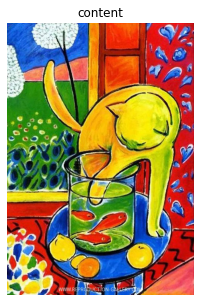

In [23]:
# device = 'cpu'

# Images
# content_im = skimage.io.imread("https://github.com/scijs/baboon-image/blob/master/baboon.png?raw=true")
content_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/matisse_cat.jpeg?raw=true")
fig, ax = plt.subplots(1,1,figsize=[5,5])
_ = plt.imshow(content_im); plt.title("content"); _ = plt.axis("off")

img_content = Image(img=content_im, optimizable=False, img_shape=[256,256]).to(device)
img_gen = Image(None, optimizable=True).to(device)

# SmallNet
net = SmallNet(pretrained_net, content_layer[-1])

# Losses
loss_fn = Losses(img_content(), 
                 tv_weight_ini=1e3, 
                 int_weight_ini=0.0,
                 clamp_weight_ini=1e1,
                 weight_adjust_bounds=[0.01, 0.1],
                 weight_adjust_fac=[1.5, 0.75])

# Optimizer
optimizer = torch.optim.LBFGS(img_gen.parameters(),lr=1.0)
abs_loss_limit = 1e-3
rel_loss_limit = 1e-7

# Jitter the input image?
jitter_nsteps = 30

In [25]:
img_content().device

device(type='cuda', index=0)

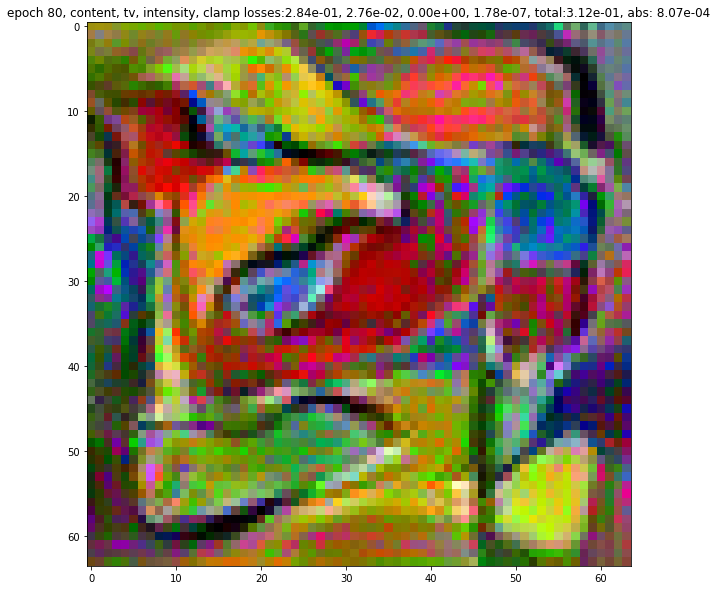

KeyboardInterrupt: ignored

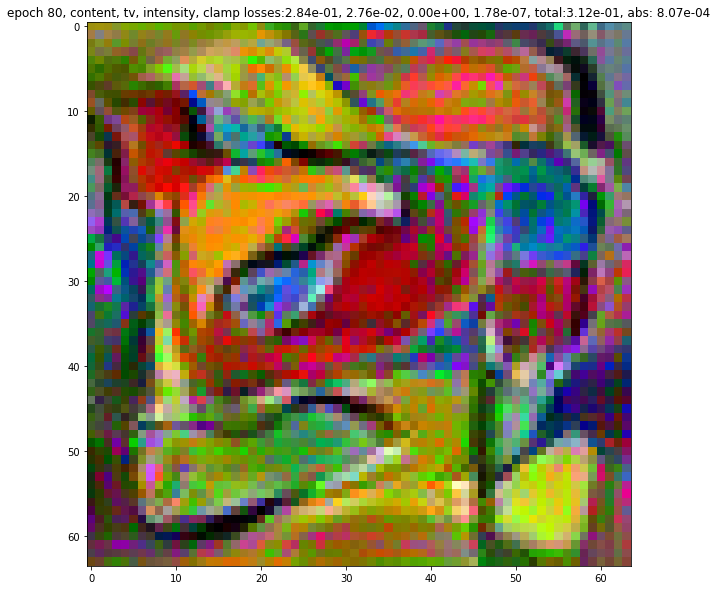

In [26]:
fig, ax = plt.subplots(1,1,figsize=[10,10])

# for sanity
if jitter_nsteps<0:
    jitter_nsteps = 0

def closure():
    optimizer.zero_grad()
    fm_gen = net(img_gen(), content_layer, gram=True)
    loss = loss_fn(img_gen(), fm_gen, fm_content)
    loss.backward()
    return loss

last_loss = 1e10
frame = 0
for i in range(1000):
    if i<jitter_nsteps:
        fm_content = net(img_content(jitter=True), content_layer, gram=True)
    elif i==jitter_nsteps:
        fm_content = net(img_content(jitter=False), content_layer, gram=True)
    optimizer.step(closure)
    loss_fn.adjust_weights()

    if i%20==0:
        with torch.no_grad():
            plt.clf()
            plt.imshow(img_gen.postprocess())
            
            plt.title(f"epoch {i:02}, content, tv, intensity, clamp losses:" + 
                      f"{loss_fn.content_weight*loss_fn.content_loss:.2e}, " + 
                      f"{loss_fn.tv_weight*loss_fn.tv_loss:.2e}, " +
                      f"{loss_fn.int_weight*loss_fn.int_loss:.2e}, " + 
                      f"{loss_fn.clamp_weight*loss_fn.clamp_loss:.2e}, "+
                      f"total:{loss_fn.total_loss:.2e}, abs: {torch.abs(last_loss-loss_fn.total_loss):.2e}")
            
            clear_output(wait = True)
            display(fig)
            
            # plt.savefig(f"./Output/Frame{frame:05d}")
            # frame += 1

            if loss_fn.total_loss<abs_loss_limit and loss_fn.clamp_loss<1e-10:
                clear_output(wait = True)
                print(f'success: absolute loss limit ({abs_loss_limit:.1e}) reached')
                break
            if torch.abs(last_loss-loss_fn.total_loss)<rel_loss_limit and loss_fn.clamp_loss<1e-10:
                clear_output(wait = True)
                print(f'stopped because relative loss limit ({rel_loss_limit:.1e})  was reached')
                break

            if loss_fn.total_loss.isnan():
                print(f'stopped because loss is NaN')
                break
                
    last_loss = loss_fn.total_loss

    with torch.no_grad():
        img_gen.img.data.clamp_(0,1)

In [9]:
img_gen().device

device(type='cuda', index=0)

In [10]:
img_content(jitter=True)

-0.8632607573327378 -0.008834575010340906 0.763636372350171 [ 0.33253172 -0.9509151 ]


tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.6784, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.6824, 0.0000, 0.0000],
          [0.0784, 0.0588, 0.0549,  ..., 0.6863, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.8824,  ..., 0.9373, 0.9451, 0.9647],
          [0.0000, 0.0000, 0.6941,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.7020,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0824, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0745, 0.0000, 0.0000],
          [0.2980, 0.3294, 0.3137,  ..., 0.0824, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.8941,  ..., 0.3608, 0.3608, 0.3647],
          [0.0000, 0.0000, 0.7843,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.8431,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1059, 0.0000, 0.0000],
          [0.7490, 0.7451, 0.7255,  ..., 0

In [13]:
img_gen().device

device(type='cuda', index=0)